In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')
%matplotlib inline
from IPython.display import display

from tyssue import config
from tyssue import Sheet, SheetGeometry as geom
from tyssue.dynamics import SheetModel as model

from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.dynamics.sheet_isotropic_model import isotropic_relax

from tyssue.draw.plt_draw import quick_edge_draw, plot_forces
from tyssue.draw.threejs_draw import view_3js

from tyssue.io import hdf5

from tyssue.core.objects import get_opposite
from tyssue.core.generation import create_anchors

from tyssue.topology.sheet_topology import cell_division, type1_transition

import warnings
import logging
log = logging.getLogger('nb')



In [2]:
def resolve_t1s(sheet, geom, solver, max_iter=60):

    l_th = sheet.settings['threshold_length']
    i = 0
    while sheet.edge_df.length.min() < l_th:

        for edge in sheet.edge_df[sheet.edge_df.length < l_th].sort_values('length').index:
            try:
                type1_transition(sheet, edge)
            except KeyError:
                continue
            log.info('transition # {} on edge {}'.format(i+1, edge))
            sheet.reset_index()
            sheet.reset_topo()
            geom.update_all(sheet)
        solver.find_energy_min(sheet, geom, model)
        i += 1
        if i > max_iter:
            warnings.warn('Max iter reached!')
            break
    
    
    

In [3]:
h5store = '../data/hf5/fullerene.hf5'

datasets = hdf5.load_datasets(h5store,
                              data_names=['face',
                                          'vert',
                                          'edge'])

specs = config.geometry.spherical_sheet()
sheet = Sheet('emin', datasets, specs)
geom.center(sheet)

geom.update_all(sheet)
sheet.vert_df.is_active = 1

sheet.edge_df['opposite'] = get_opposite(sheet.edge_df)

nondim_specs = config.dynamics.quasistatic_sheet_spec()
dim_model_specs = model.dimentionalize(nondim_specs)
sheet.update_specs(dim_model_specs, reset=True)
isotropic_relax(sheet, nondim_specs)
sheet.settings['threshold_length'] = 1e-2
geom.update_all(sheet)
res = solver.find_energy_min(sheet, geom, model)

renderer, line = view_3js(sheet)
display(renderer)

### Single cell division:

```python
mother = 16

cell_division(sheet, 16, geom, angle=0)
geom.center(sheet)

res = solver.find_energy_min(sheet, geom, model)
print(res['success'])

fig, ax = quick_edge_draw(sheet, ['z', 'x'])
```

In [4]:
%pdb

Automatic pdb calling has been turned ON


In [5]:
ngen = 1
for n in range(ngen):
    live_cells = np.array(sheet.face_df[sheet.face_df.is_alive==1].index)
    np.random.shuffle(live_cells)
    print('Generation {}: {} cells to devide'
         .format(n, len(live_cells)))
    for cell in live_cells:
        daughter = cell_division(sheet, cell, geom, angle=0)
        if daughter is None:
            continue
    isotropic_relax(sheet, nondim_specs)
    #res = solver.find_energy_min(sheet, geom, model)
    #resolve_t1s(sheet, geom, solver, max_iter=60)
    

resolve_t1s(sheet, geom, solver, max_iter=60)
res = solver.find_energy_min(sheet, geom, model)


Generation 0: 32 cells to devide


In [7]:
renderer, line = view_3js(sheet)
display(renderer)

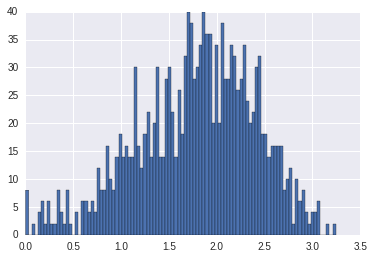

In [44]:
fig, ax = plt.subplots()

h= ax.hist(sheet.edge_df.length, bins=100)

In [28]:
from tyssue.io import hdf5

In [29]:
sheet.Nf, sheet.Ne, sheet.Nv

(1024, 6120, 2040)

In [8]:
from tyssue.core.generation import extrude

organo_datasets = extrude(sheet.datasets, scale=0.9)



from tyssue import Monolayer, MonoLayerGeometry
from tyssue.config.geometry import bulk_spec

organo = Monolayer('colo', organo_datasets, bulk_spec())
renderer, line = view_3js(organo)
display(renderer)

In [48]:
hdf5.save_datasets('../data/hf5/small_organo.hf5', organo)

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2885: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['letter', 'segment']]

  exec(code_obj, self.user_global_ns, self.user_ns)
/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2885: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['contractility', 'vol_elasticity', 'prefered_height', 'prefered_area', 'prefered_vol', 'height', 'rho', 'vol', 'basal_shift', 'segment']]

  exec(code_obj, self.user_global_ns, self.user_ns)


In [32]:
organo.data_names

['vert', 'edge', 'cell', 'face']

In [33]:
to_rm_faces = organo.face_df['x'] < 0

to_rm_edges = organo.upcast_face(to_rm_faces)
organo.remove(to_rm_edges)
organo.reset_index()
organo.reset_topo()


In [34]:
renderer, line = view_3js(organo)
display(renderer)


In [35]:
from tyssue.io import obj

In [36]:
basal = organo.get_sub_sheet('basal')
apical = organo.get_sub_sheet('apical')
lateral = organo.get_sub_sheet('sagital')


In [37]:
obj.save_junction_mesh('../data/obj/half_organo.obj', organo)

obj.save_junction_mesh('../data/obj/half_organo_basal.obj', basal)
obj.save_junction_mesh('../data/obj/half_organo_apical.obj', apical)
obj.save_junction_mesh('../data/obj/half_organo_lateral.obj', lateral)



                be advised the file cannot be read back in vispy
                be advised the file cannot be read back in vispy
                be advised the file cannot be read back in vispy


In [171]:
up_pos = (sheet.upcast_srce(sheet.vert_df[sheet.coords]) - 
          sheet.upcast_face(sheet.face_df[sheet.coords]).values)
up_pos['face'] = sheet.edge_df['face']
up_pos['srce'] = sheet.edge_df['srce']

def _svd(df):
    u, s, v = np.linalg.svd(df[['x', 'y', 'z']],
                            full_matrices=False)
    rot = np.dot(df[list('xyz')], v.T)
    srces = df['srce']
    #cols = ['sx', 'sy', 'sz',
    #        'v_xx', 'v_xy', 'v_xz',
    #        'v_yx', 'v_yy', 'v_yz',
    #        'v_zx', 'v_zy', 'v_zz',]
    
    #data = pd.Series(np.hstack((s, v.ravel())),
    #                 index=cols)
    cols = ['u', 's', 'v', 'rot', 'srce']
    
    data = pd.Series(index=cols, data=[u, s, v, rot, srces.values], dtype=object)
    return data

usv = up_pos.groupby('face').apply(_svd)